#### Dependencies

In [30]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#### Download the dataset from its original source by running the cell below.

In [31]:

!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-08-01 14:09:25--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.212.72.155, 2600:1404:6400:1583::317f, 2600:1404:6400:1595::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.212.72.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   113MB/s    in 10s     

2023-08-01 14:09:36 (78.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [32]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


#### Create directory for cats-v-dogs, and subdirectories for training

In [34]:

root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_dir):
  training_dir = os.path.join(root_dir, "training")
  validation_dir = os.path.join(root_dir, "validation")

  training_cats_dir = os.path.join(training_dir, "cats")
  training_dogs_dir = os.path.join(training_dir, "dogs")

  validation_cats_dir = os.path.join(validation_dir, "cats")
  validation_dogs_dir = os.path.join(validation_dir, "dogs")

  os.makedirs(training_cats_dir, exist_ok=True)
  os.makedirs(training_dogs_dir, exist_ok=True)
  os.makedirs(validation_cats_dir, exist_ok=True)
  os.makedirs(validation_dogs_dir, exist_ok=True)


In [35]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


#### Split Data into Training and Test Sets

In [20]:

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  files  = os.listdir(SOURCE_DIR)
  random.shuffle(files)
  split_index = int(SPLIT_SIZE * len(files))
  training_files = files[:split_index]
  validation_files = files[split_index:]

  for file in training_files:
    file_path = os.path.join(SOURCE_DIR, file)
    if os.path.getsize(file_path) > 0:
      shutil.copy(file_path, os.path.join(TRAINING_DIR, file))
    else:
      print(f"{file} is zero length, so ignoring.")

  for file in validation_files:
    file_path = os.path.join(SOURCE_DIR, file)
    if os.path.getsize(file_path) > 0:
      shutil.copy(file_path, os.path.join(VALIDATION_DIR, file))
    else:
      print(f"{file} is zero length, so ignoring.")


In [21]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)


print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


#### Use image generators to generate our data from directories

In [22]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255)
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,batch_size=20,class_mode='binary',target_size=(150 , 150))
  validation_datagen = ImageDataGenerator(rescale=1/255)
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,batch_size=20,class_mode='binary',target_size=(150, 150))
  return train_generator, validation_generator

In [23]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#### Create our CNN model

In [24]:
from tensorflow.keras.optimizers import RMSprop

def create_model():
  
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
  model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [25]:
model = create_model()
history = model.fit(train_generator,epochs=15,verbose=1,validation_data=validation_generator)

Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.6721

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 67s 45ms/step - loss: 0.5902 - accuracy: 0.6721 - val_loss: 0.4717 - val_accuracy: 0.7704
Epoch 2/15
1125/1125 [==============================] - 49s 44ms/step - loss: 0.4606 - accuracy: 0.7820 - val_loss: 0.4296 - val_accuracy: 0.8088
Epoch 3/15
1125/1125 [==============================] - 48s 42ms/step - loss: 0.3782 - accuracy: 0.8322 - val_loss: 0.3415 - val_accuracy: 0.8516
Epoch 4/15
1125/1125 [==============================] - 48s 43ms/step - loss: 0.3132 - accuracy: 0.8634 - val_loss: 0.3478 - val_accuracy: 0.8512
Epoch 5/15
1125/1125 [==============================] - 47s 41ms/step - loss: 0.2587 - accuracy: 0.8949 - val_loss: 0.3023 - val_accuracy: 0.8728
Epoch 6/15
1125/1125 [==============================] - 48s 43ms/step - loss: 0.2157 - accuracy: 0.9137 - val_loss: 0.2992 - val_accuracy: 0.8760
Epoch 7/15
1125/1125 [==============================] - 48s 42ms/step - loss: 0.1721 - accuracy: 0.9348 - val_loss: 0.4004 - val_accura

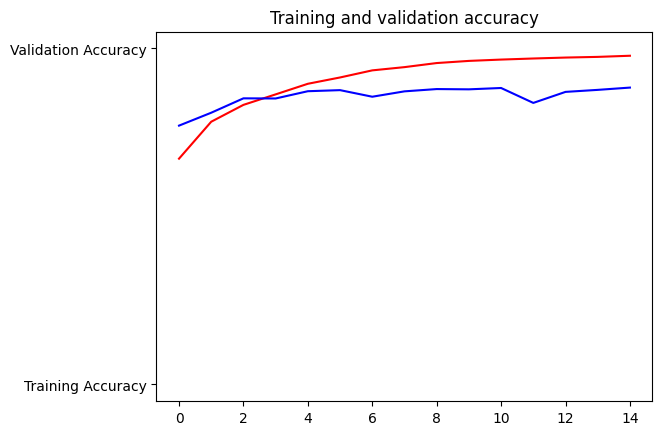

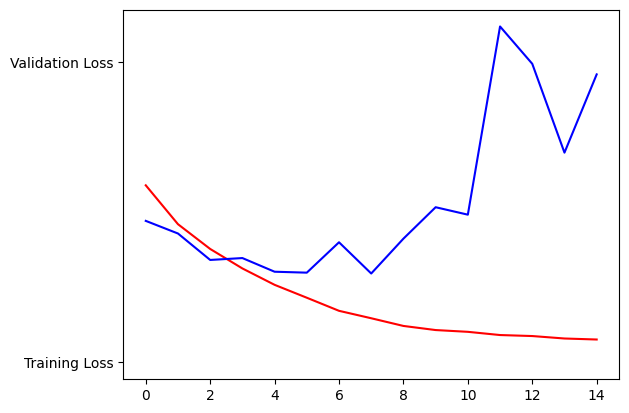

In [26]:
# get training datas
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

As you can see our model has reacher almost 89% with bigger dataset with the same CNN.<br>
And This is good =) <br>
Thanks for reading this notebook, I hope you enjoyed it and learned something new.<br>